## Predicción sobre los precios de las acciones de Google

**Autor: Luis Fernando Apáez Álvarez**


#### Índice

<ul>
    <a href="#p1"><li>Descripción</li></a>
    <a href="#p2"><li>Implementación del modelo</li></a>
</ul>

---

### Descripción <a id="p1"></a>

En este proyecto ajustamos tres diferentes tipos de modelos, cuyos resultados fueron:

Modelo|Error porcentual promedio|Error en la predicción de interés|std|
---|---|---|---|
Regresión lineal múltiple|0.67%|0.69%|0.87%|
Red neuronal MLP|0.8%|0.31%|0.86%|
Red neuronal LSTM|2.47%|3.18%|2.06%|

A pesar de que la red neuronal MLP obtuve una mejor predicción para la información de interés, el modelo que fue mejor es el referente a la regresión lineal múltiple.

Lo que haremos ahora será ajustar 4 modelos predictivos de regresión lineal múltiple (para ``Open, Close, low, High`` respectivamente) de la siguiente manera:

* Con la información del dataset que tenemos realizaremos la predicción del precio de apertura del día siguiente.
* De igual manera, con otros tres modelos realizaremos la predicción de los precios de ``Low, Close, High`` del día siguiente.
* Con todo lo anterior conseguiremos tener la información predicha de ``Open, Close, low, High`` para un día en el cual no tenemos información.
* Con la información obtenida anteriormente y con la del dataset original, predeciremos ahora los precios del día posterior siguiente. Por ejemplo, con los datos originales predecimos los precios para el día $t$. Luego, una vez predichos los precios para ese día, utilizaremos los precios de los días $s\leq t$ para predecir ahora los precios para el día $t+1$ y así sucesivamente.

### Implementación del modelo <a id="p2"></a>

#### Idea general

Con el siguiente código conseguimos obtener la predicción del precio de apertura para el día siguiente al 28 de octubre del 2022:

In [1]:
# Importaciones necesarias
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
plt.style.use('seaborn')

# Instanciamos y configuramos la clave de google
goog = yf.Ticker('goog')
# Obtenemos la informacion
data = goog.history(interval='1d', start='2016-01-01', end='2022-10-31')
data = data.reset_index()
# Los precios de apertura parten del indice 1 (omitimos la primera
# observacion de indice 0)
data_p = pd.DataFrame(data.loc[1:1718, "Open"]).reset_index()
# El resto de la informacion parte del primer indice, pero no contempla
# el ultimo
data_p["High"] = data.loc[0:1717, "High"]
data_p["Low"] = data.loc[0:1717, "Low"]
data_p["Close"] = data.loc[0:1717, "Close"]
data_p = data_p.drop("index", axis=1)

# Instanciamos
reglin = LinearRegression()

# Definimos las variables
X = data_p[["High", "Low", "Close"]].values
y = data_p["Open"].values.reshape(-1, 1)

# Realizamos la division de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=123)

# Ajustamos (entrenamos)
reglin.fit(X_train, y_train)

# Realizamos las predicciones de la variable "y" sobre el conjunto de pruebas
y_pred = reglin.predict(X_test)

# error cuadratico medio
mse = mean_squared_error(y_pred, y_test)

# R^2
r2 = r2_score(y_pred, y_test)

# veamos
print("Métricas:")
print(f'mse = {mse}\nR^2 = {r2}')

# Dataframe con la informacion
df_info = pd.DataFrame(y_pred).rename(columns = {0: 'y_pred'})
df_info['y_test'] = y_test
df_info = df_info.reset_index()

# Calculamos las diferencias absolutas entre los valores reales y los predichos
df_info['diff'] = abs(df_info.y_pred - df_info.y_test)

# Calculamos el porcentaje de error para cada fila
df_info['error (%)'] = (df_info['diff'] * 100) / df_info['y_test']

# Estadisticas sobre las predicciones
print()
print("Estadísticas:")
display(df_info.describe()["error (%)"])

# Definimos los valores nuevos de las variables regresoras
X_new = data.loc[1718, ["High", "Low", "Close"]].values.reshape(1, 3)

# Predecimos utilizando el modelo reglin
y_pred_new = reglin.predict(X_new)

# Veamos
print(f'Valor para el 31-10-2022: {y_pred_new[0][0]}')

Métricas:
mse = 0.7872634840561122
R^2 = 0.9993266842527836

Estadísticas:


count    430.000000
mean       0.674820
std        0.879015
min        0.000615
25%        0.189228
50%        0.413420
75%        0.808264
max        7.652582
Name: error (%), dtype: float64

Valor para el 31-10-2022: 96.43814594627618


Lo que sigue es implementar tres modelos idénticos al anterior para predecir los valores de ``Low, Close, High``. Para ello definimos la siguiente función

In [2]:
def prediccion(X_reg, y_res, data_aux):
    """X: lista con los nombres de las variables regresoras;
       y: cadena de texto referente al nombre de la variable de respuesta.
       data_aux: dataframe con la informacion."""
    # Instanciamos
    reglin = LinearRegression()
    # Definimos las variables
    X = data_aux[X_reg].values
    y = data_aux[y_res].values.reshape(-1, 1)
    # Realizamos la division de los datos
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.25,
                                                       random_state=123)
    # Ajustamos (entrenamos)
    reglin.fit(X_train, y_train)
    # Realizamos las predicciones de la variable "y" sobre el conjunto de pruebas
    y_pred = reglin.predict(X_test)
    # data_auxframe con la informacion
    df_info = pd.DataFrame(y_pred).rename(columns = {0: 'y_pred'})
    df_info['y_test'] = y_test
    df_info = df_info.reset_index()
    # Calculamos las diferencias absolutas entre los valores reales y los predichos
    df_info['diff'] = abs(df_info.y_pred - df_info.y_test)
    # Calculamos el porcentaje de error para cada fila
    df_info['error (%)'] = (df_info['diff'] * 100) / df_info['y_test']
    # Estadisticas sobre las predicciones
    df_stats = df_info.describe()["error (%)"]
    # Definimos los valores nuevos de las variables regresoras
    X_new = data.loc[1718, X_reg].values.reshape(1, 3)
    # Predecimos utilizando el modelo reglin
    y_pred_new = reglin.predict(X_new)
    
    # Retornamos el valor de la prediccion y la serie con informacion
    # de algunas estadisticas sobre los errores porcentuales
    return y_pred_new[0][0], df_stats

Utilizamos la función anterior

In [3]:
pred_close, df_stats_close = prediccion(["High", "Low", "Open"], "Close", data_p)
pred_low, df_stats_low = prediccion(["High", "Open", "Close"], "Low", data_p)
pred_high, df_stats_high = prediccion(["Open", "Low", "Close"], "High", data_p)
pred_open, df_stats_open = prediccion(["High", "Low", "Close"], "Open", data_p)

print("Predicciones para el día 31 de octubre del 2022:")
print(f'Open: {pred_open}')
print(f'low: {pred_low}')
print(f'high: {pred_high}')
print(f'Close: {pred_close}')

Predicciones para el día 31 de octubre del 2022:
Open: 96.43814594627618
low: 95.2515341482621
high: 96.08836426598155
Close: 93.81752952066105


In [4]:
display(df_stats_open)
display(df_stats_high)
display(df_stats_low)
display(df_stats_close)

count    430.000000
mean       0.674820
std        0.879015
min        0.000615
25%        0.189228
50%        0.413420
75%        0.808264
max        7.652582
Name: error (%), dtype: float64

count    430.000000
mean       0.669495
std        0.636570
min        0.002276
25%        0.262821
50%        0.556750
75%        0.824435
max        4.956993
Name: error (%), dtype: float64

count    430.000000
mean       0.662731
std        0.732066
min        0.000624
25%        0.254185
50%        0.498132
75%        0.809657
max        5.724562
Name: error (%), dtype: float64

count    430.000000
mean       0.463031
std        0.485965
min        0.002109
25%        0.147989
50%        0.309214
75%        0.597531
max        3.628384
Name: error (%), dtype: float64

Vemos que en general las predicciones fueron muy buenas, en particular, el modelo predijo mejor para los precios de cierre.

Lo que sigue es agregrar esa información nueva al dataframe original y volver a repetir el proceso.

In [5]:
# Creamos un dataframe con la informacion nueva
info_nueva = pd.DataFrame(["t", pred_open, pred_high, pred_low, pred_close]).transpose()
info_nueva = info_nueva.rename(columns={0: "Date", 1: "Open", 2: "High", 3: "Low", 4: "Close"})
info_nueva

,Date,Open,High,Low,Close
0,t,96.438146,96.088364,95.251534,93.81753


In [12]:
# Cambiamos el indice
info_nueva = info_nueva.rename(index={0: len(data)})
info_nueva

,Date,Open,High,Low,Close
1719,t,96.438146,96.088364,95.251534,93.81753


In [6]:
# Veamos de nuevo el dataframe original
data = data[["Date", "Open", "High", "Low", "Close"]]
display(data.head())
print(data.shape)

,Date,Open,High,Low,Close
0,2016-01-04,37.150002,37.202999,36.562901,37.091999
1,2016-01-05,37.322498,37.599998,36.931999,37.129002
2,2016-01-06,36.500000,37.359001,36.445999,37.181000
3,2016-01-07,36.515499,36.924999,35.952999,36.319500
4,2016-01-08,36.572498,36.661499,35.650002,35.723499


(1719, 5)


Concatenamos (o apilamos) los dos dataframes

In [14]:
pd.concat([data, info_nueva]).tail()

,Date,Open,High,Low,Close
1715,2022-10-25 00:00:00,103.300003,105.099998,103.019997,104.93
1716,2022-10-26 00:00:00,96.760002,98.540001,94.57,94.82
1717,2022-10-27 00:00:00,94.309998,95.169998,91.900002,92.599998
1718,2022-10-28 00:00:00,92.529999,96.860001,92.322998,96.580002
1719,t,96.438146,96.088364,95.251534,93.81753


#### Implemetnación

Lo que sigue es repetir el proceso que hicimos antes, pero configurándolo mediante una función (digamos ``fun_forecast()``). Dicha función hará lo siguiente:

* Le pasaremos un número entero positivo que representa el número de tiempos $t$ a predecir, donde dichos nuevos valores estarán al final de una copia del dataframe base ``data``. dicha copia de ``data`` será el valor que nos retorne la función.

De tal manera, escribimos

In [18]:
# Modificamos la funcion prediccion que habiamos definido antes
def prediccion_pred(X_reg, y_res, data_origi, data_aux):
    """X: lista con los nombres de las variables regresoras;
       y: cadena de texto referente al nombre de la variable de respuesta;
       data_origi: dataframe con la información conjunta de los precios;
       data_aux: dataframe con la informacion desfasada en un día para predecir
                 el precio del día siguiente."""
    # Instanciamos
    reglin = LinearRegression()
    # Definimos las variables
    X = data_aux[X_reg].values
    y = data_aux[y_res].values.reshape(-1, 1)
    # Realizamos la division de los datos
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.25,
                                                       random_state=123)
    # Ajustamos (entrenamos)
    reglin.fit(X_train, y_train)
    # Definimos los valores nuevos de las variables regresoras
    X_new = data_origi.loc[len(data_origi)-1, X_reg].values.reshape(1, 3)
    # Predecimos utilizando el modelo reglin
    y_pred_new = reglin.predict(X_new)
    # Retornamos el valor de la prediccion
    return y_pred_new[0][0]

# Ahora si...
def fun_forecast(n):
    """Función para realizar el pronóstico de los precios de apertura, cierre,
    los precios más altos y bajos en un día de las acciones de Google.
    La función recibe como parámetro un número entero n referente al número de
    períodos a pronósticar y retorna un dataframe con toda la información."""
    # Copia del dataframe original
    data_0 = goog.history(interval='1d', start='2016-01-01', end='2022-10-31')
    data_0 = data_0.reset_index()
    data_0 = data_0[["Date", "Open", "High", "Low", "Close"]]
    
    # Controlamos posible error
    if (n > 0) and (type(n) == type(0)):
        for i in range(n):
            # --------------------------------------------------------------------
            # CREACION DEL DATAFRAME CON LA INFORMACION DESFASADA PARA REALIZAR LA
            # PREDICCION.
            # Los precios de apertura parten del indice 1 (omitimos la primera
            # observacion de indice 0)
            data_p = pd.DataFrame(data_0.loc[1: , "Open"]).reset_index()
            # El resto de la informacion parte del primer indice, pero no contempla
            # el ultimo
            data_p["High"] = data_0.loc[0:len(data_0)-2, "High"]
            data_p["Low"] = data_0.loc[0:len(data_0)-2, "Low"]
            data_p["Close"] = data_0.loc[0:len(data_0)-2, "Close"]
            data_p = data_p.drop("index", axis=1)

            # --------------------------------------------------------------------
            # PREDICCION DE LOS PRECIOS PARA EL DIA SIGUIENTE
            pred_close = prediccion_pred(["High", "Low", "Open"], "Close", data_0, data_p)
            pred_low = prediccion_pred(["High", "Open", "Close"], "Low", data_0, data_p)
            pred_high = prediccion_pred(["Open", "Low", "Close"], "High", data_0, data_p)
            pred_open = prediccion_pred(["High", "Low", "Close"], "Open", data_0, data_p)

            # --------------------------------------------------------------------
            # CREAMOS UN DATAFRAME CON LA INFORMACION OBTENIDA ANTES
            cad_aux = "t + " + str(i)
            info_nueva = pd.DataFrame([cad_aux, pred_open, pred_high, pred_low, pred_close]).transpose()
            info_nueva = info_nueva.rename(columns={0: "Date", 1: "Open", 2: "High", 3: "Low", 4: "Close"})
            info_nueva = info_nueva.rename(index={0: len(data_0)})
            # AGREGAMOS LA INFORMACION NUEVA AL DATAFRAME BASE
            data_0 = pd.concat([data_0, info_nueva])

        # Retornamos el dataframe con la información nueva
        return data_0
    else:
        return "n debe ser un entero positivo"

Realicemos una prueba realizando un pronóstico a 10 tiempos futuros:

In [19]:
data_10 = fun_forecast(10)
data_10.tail(11)

,Date,Open,High,Low,Close
1718,2022-10-28 00:00:00,92.529999,96.860001,92.322998,96.580002
1719,t + 0,96.438146,96.088364,95.251534,93.81753
1720,t + 1,94.033306,95.697231,93.388678,95.951627
1721,t + 2,95.708285,96.298363,94.368667,94.377298
1722,t + 3,94.518132,95.775673,93.72009,95.444571
1723,t + 4,95.403977,96.108984,94.158469,94.684339
1724,t + 5,94.759005,95.867478,93.866003,95.192229
1725,t + 6,95.138967,96.013897,94.080772,94.839552
1726,t + 7,94.834829,95.924095,93.907795,95.078881
1727,t + 8,95.112824,95.989707,94.039618,94.867489


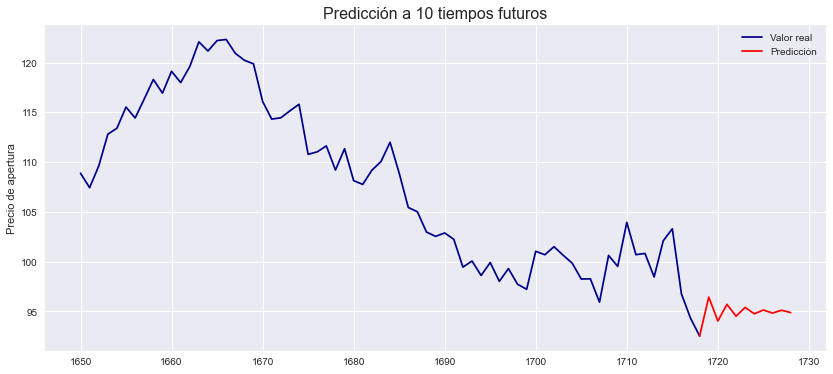

In [35]:
# Graficamente

plt.figure(figsize=(14,6))
plt.plot(np.arange(1650, len(data_10)-10), data_10["Open"][1650:len(data_10)-10], 
         color='darkblue', label='Valor real')
plt.plot(np.arange(len(data_10)-11, len(data_10)), data_10["Open"][len(data_10)-11: len(data_10)], 
                   color='red', label='Predicción')
plt.title("Predicción a 10 tiempos futuros", size=16)
plt.ylabel("Precio de apertura")
plt.legend()
plt.show()

Notamos que las primeras predicciones son buenas y diferentes, luego, a partir de cierto punto las predicciones se van estabilizando.

En comparativa, veamos los precios reales para esos 10 tiempos en los cuales realizamos las predicciones:

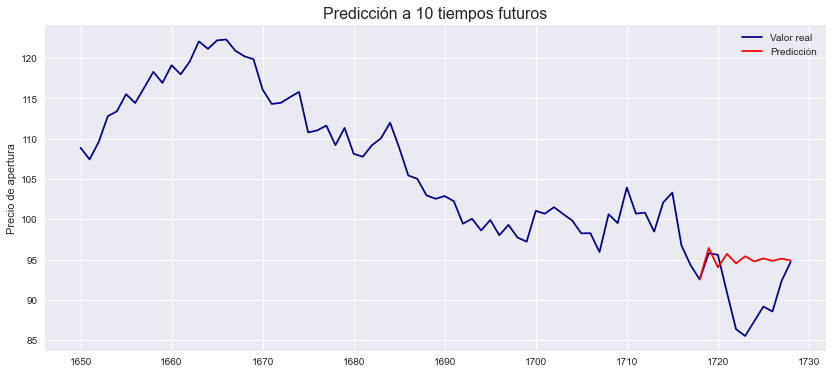

In [40]:
plt.figure(figsize=(14,6))

# Cargamos los datos
data_o = goog.history(interval='1d', start='2016-01-01', end='2022-11-14')

# Graficamos
plt.plot(np.arange(1650, len(data_o)), data_o["Open"][1650:len(data_o)], 
         color='darkblue', label='Valor real')
plt.plot(np.arange(len(data_10)-11, len(data_10)), data_10["Open"][len(data_10)-11: len(data_10)], 
                   color='red', label='Predicción')
plt.title("Predicción a 10 tiempos futuros", size=16)
plt.ylabel("Precio de apertura")
plt.legend()
plt.show()

De nuevo, notamos que las primeras predicciones son buenas, pero el resto tendió a alejarse, no obstante, la última observación: 

In [41]:
display(data_10.tail(1))
display(data_o.tail(1))

,Date,Open,High,Low,Close
1728,t + 9,94.882578,95.939638,93.932225,95.043535


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-11-11,94.709999,97.360001,94.160004,96.730003,30569100,0,0.0


obtuve una muy buena predicción por el modelo, de hecho, para esa última observación

In [43]:
print(f'Error porcentual: {round((94.882578-94.709999) * 100 / (94.709999), 2)}%')

Error porcentual: 0.18%


Lo cual puede ser debido a que los precios se están estabilizando en sus precios pasados, de modo que la tendencia que tenían a la baja, regresa con una tendencia a la alza, lo cual se intersecta con la tendencia constante de las predicciones.

Veamos ahora las predicciones para los precios de cierre

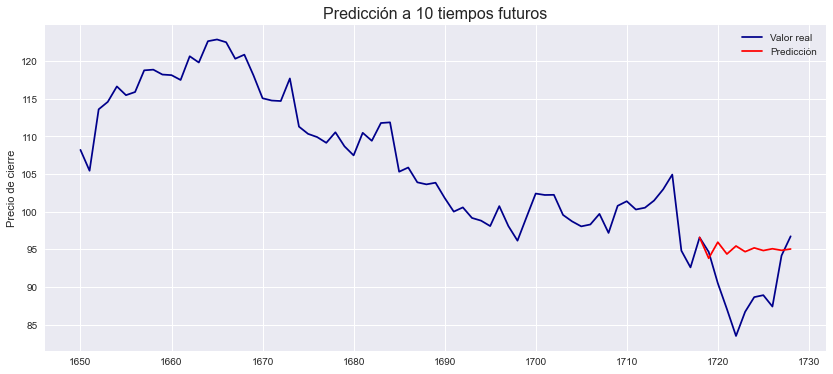

In [44]:
plt.figure(figsize=(14,6))

# Graficamos
plt.plot(np.arange(1650, len(data_o)), data_o["Close"][1650:len(data_o)], 
         color='darkblue', label='Valor real')
plt.plot(np.arange(len(data_10)-11, len(data_10)), data_10["Close"][len(data_10)-11: len(data_10)], 
                   color='red', label='Predicción')
plt.title("Predicción a 10 tiempos futuros", size=16)
plt.ylabel("Precio de cierre")
plt.legend()
plt.show()

Veamos ahora las predicciones para los precios más altos en el día

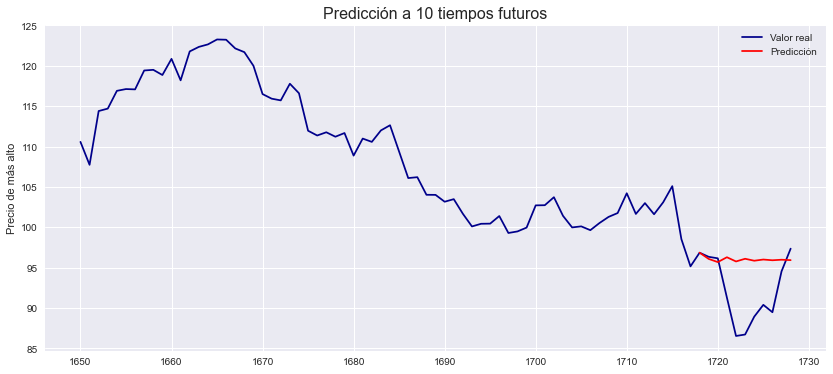

In [45]:
plt.figure(figsize=(14,6))

# Graficamos
plt.plot(np.arange(1650, len(data_o)), data_o["High"][1650:len(data_o)], 
         color='darkblue', label='Valor real')
plt.plot(np.arange(len(data_10)-11, len(data_10)), data_10["High"][len(data_10)-11: len(data_10)], 
                   color='red', label='Predicción')
plt.title("Predicción a 10 tiempos futuros", size=16)
plt.ylabel("Precio de más alto")
plt.legend()
plt.show()

Veamos ahora las predicciones para los precios más bajos en el día

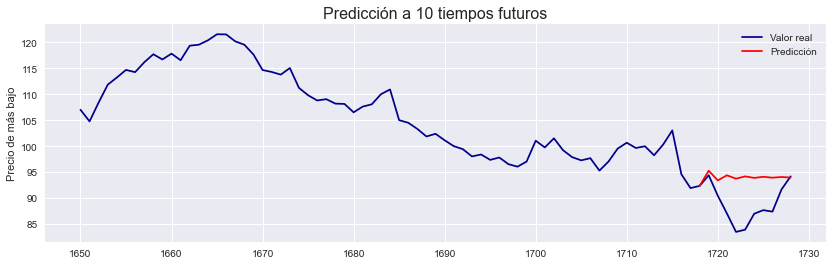

In [47]:
plt.figure(figsize=(14,4))

# Graficamos
plt.plot(np.arange(1650, len(data_o)), data_o["Low"][1650:len(data_o)], 
         color='darkblue', label='Valor real')
plt.plot(np.arange(len(data_10)-11, len(data_10)), data_10["Low"][len(data_10)-11: len(data_10)], 
                   color='red', label='Predicción')
plt.title("Predicción a 10 tiempos futuros", size=16)
plt.ylabel("Precio de más bajo")
plt.legend()
plt.show()

Se concluye entonces que el modelo obtiene buenas predicciones iniciales y, depsués de ello, tiende a estabilizarse.

Finalmente, modificaremos la función ``fun_forecast()`` para poder modificar las fechas de inicio y de fin del dataframe con la información base, de modo que podremos obtener predicciones para diferentes fechas y decidir cuánta información utilizar para las predicciones. De tal manera

In [48]:
def fun_forecast_x(fecha_inicio, fecha_fin, n=3):
    """Función para realizar el pronóstico de los precios de apertura, cierre,
    los precios más altos y bajos en un día de las acciones de Google.
    La función recibe como parámetro un número entero n referente al número de
    períodos a pronósticar y retorna un dataframe con toda la información."""
    # Copia del dataframe original
    data_0 = goog.history(interval='1d', start=fecha_inicio, end=fecha_fin)
    data_0 = data_0.reset_index()
    data_0 = data_0[["Date", "Open", "High", "Low", "Close"]]
    
    # Controlamos posible error
    if (n > 0) and (type(n) == type(0)):
        for i in range(n):
            # --------------------------------------------------------------------
            # CREACION DEL DATAFRAME CON LA INFORMACION DESFASADA PARA REALIZAR LA
            # PREDICCION.
            # Los precios de apertura parten del indice 1 (omitimos la primera
            # observacion de indice 0)
            data_p = pd.DataFrame(data_0.loc[1: , "Open"]).reset_index()
            # El resto de la informacion parte del primer indice, pero no contempla
            # el ultimo
            data_p["High"] = data_0.loc[0:len(data_0)-2, "High"]
            data_p["Low"] = data_0.loc[0:len(data_0)-2, "Low"]
            data_p["Close"] = data_0.loc[0:len(data_0)-2, "Close"]
            data_p = data_p.drop("index", axis=1)

            # --------------------------------------------------------------------
            # PREDICCION DE LOS PRECIOS PARA EL DIA SIGUIENTE
            pred_close = prediccion_pred(["High", "Low", "Open"], "Close", data_0, data_p)
            pred_low = prediccion_pred(["High", "Open", "Close"], "Low", data_0, data_p)
            pred_high = prediccion_pred(["Open", "Low", "Close"], "High", data_0, data_p)
            pred_open = prediccion_pred(["High", "Low", "Close"], "Open", data_0, data_p)

            # --------------------------------------------------------------------
            # CREAMOS UN DATAFRAME CON LA INFORMACION OBTENIDA ANTES
            cad_aux = "t + " + str(i)
            info_nueva = pd.DataFrame([cad_aux, pred_open, pred_high, pred_low, pred_close]).transpose()
            info_nueva = info_nueva.rename(columns={0: "Date", 1: "Open", 2: "High", 3: "Low", 4: "Close"})
            info_nueva = info_nueva.rename(index={0: len(data_0)})
            # AGREGAMOS LA INFORMACION NUEVA AL DATAFRAME BASE
            data_0 = pd.concat([data_0, info_nueva])
            
        # Graficamos los precios de apertura
        plt.figure(figsize=(14,4))
        plt.plot(np.arange(len(data_0)-100, len(data_0)-n), 
                 data_o["Open"][len(data_0)-100:len(data_0)-n], color='darkblue', 
                 label='Valor real')
        plt.plot(np.arange(len(data_0)-n-1, len(data_0)), 
                 data_10["Open"][len(data_0)-n-1: len(data_0)], color='red', 
                 label='Predicción')
        plt.title(f"Predicción a {n} tiempos futuros", size=16)
        plt.ylabel("Precio de apertura")
        plt.legend()
        plt.show()

        # Retornamos el dataframe con la información nueva
        return data_0
    else:
        return "n debe ser un entero positivo"

El día de hoy en que acabamos este proyecto es:

In [52]:
import datetime

hora_actual = datetime.datetime.now()
print(hora_actual)

2023-02-15 08:27:12.558019


Lo que haremos será realizar un pronóstico de los precios de apertura de los tres días siguientes a la fecha actual 

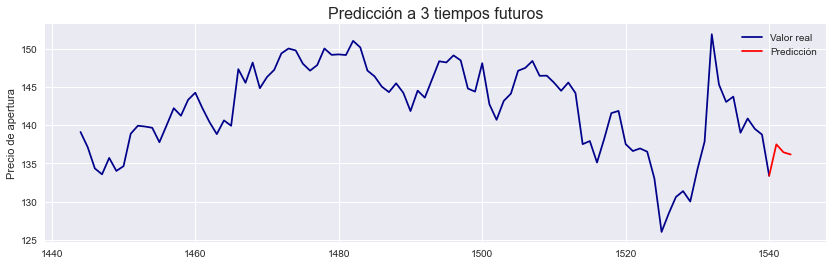

In [50]:
# Probamos 
df_f_1 = fun_forecast_x('2016-01-01', '2022-02-15')

In [51]:
df_f_1.tail(10)

,Date,Open,High,Low,Close
1534,2022-02-04 00:00:00,143.016998,144.535248,139.817505,143.016006
1535,2022-02-07 00:00:00,143.709,143.846497,138.699005,138.938004
1536,2022-02-08 00:00:00,138.991257,139.837097,136.873001,139.212997
1537,2022-02-09 00:00:00,140.849747,142.175507,140.376999,141.453003
1538,2022-02-10 00:00:00,139.5,141.431,138.050003,138.602493
1539,2022-02-11 00:00:00,138.75,139.283249,133.288498,134.130005
1540,2022-02-14 00:00:00,133.365494,136.166504,133.302002,135.300003
1541,t + 0,135.41008,136.283879,133.816366,134.343276
1542,t + 1,134.429376,135.954547,133.218332,135.100347
1543,t + 2,135.18711,136.216182,133.655371,134.499407
